In [ ]:
#|default_exp calibration

# Calibration

>Functionality to calibrate a trained, binary classification model using temperature scaling.

In [ ]:
#|export
from tsai.imports import *
from sklearn.calibration import calibration_curve
from tsai.data.core import *

In [ ]:
#|export
class ModelWithTemperature(nn.Module):
    """ A decorator which wraps a model with temperature scaling """

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1,1))

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        temperature = self.temperature.expand(logits.size(0), logits.size(1)).to(logits.device)
        return torch.div(logits, temperature)


class TemperatureSetter(nn.Module):
    """ Calibrates a binary classification model optimizing temperature """

    def __init__(self, model, lr=0.01, max_iter=1_000, line_search_fn=None, n_bins=10, verbose=True):
        super().__init__()
        self.model = ModelWithTemperature(model) if not hasattr(model, 'temperature_scale') else model
        self.lr, self.max_iter, self.line_search_fn, self.n_bins, self.verbose = lr, max_iter, line_search_fn, n_bins, verbose
        self.nll_criterion = CrossEntropyLossFlat()
        self.ece_criterion = ECELoss(n_bins)

    def forward(self, dl):
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in dl:
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list)
            labels = torch.cat(labels_list)

        if self.verbose:
            before_temperature_nll = self.nll_criterion(logits, labels).item()
            before_temperature_ece = self.ece_criterion(logits, labels).item()
            print(f'Before temperature - NLL: {before_temperature_nll:.3f}, ECE: {before_temperature_ece:.3f}')

        optimizer = torch.optim.LBFGS([self.model.temperature], lr=self.lr, max_iter=self.max_iter, line_search_fn=self.line_search_fn)

        def _evaluation():
            optimizer.zero_grad()
            loss = self.nll_criterion(self.model.temperature_scale(logits), labels)
            loss.backward()
            return loss

        pv('Calibrating the model...', self.verbose)
        optimizer.step(_evaluation)
        pv('...model calibrated', self.verbose)

        if self.verbose:
            after_temperature_nll = self.nll_criterion(self.model.temperature_scale(logits), labels).item()
            after_temperature_ece = self.ece_criterion(self.model.temperature_scale(logits), labels).item()
            print(f'Optimal temperature: {self.model.temperature.item():.3f}')
            print(f'After temperature  - NLL: {after_temperature_nll:.3f}, ECE: {after_temperature_ece:.3f}\n')

        self.logits = logits
        self.scaled_logits = self.model.temperature_scale(logits)
        self.labels = labels
        self.calibrated_model = self.model
        return self.calibrated_model


class ECELoss(nn.Module):
    """Calculates the Expected Calibration Error of a model."""
    def __init__(self, n_bins=10):
        super().__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        if isinstance(softmaxes, TSTensor):
            confidences, predictions = confidences.data, predictions.data
        accuracies = torch.eq(predictions.data, labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        return ece

In [ ]:
#|export
def plot_calibration_curve(labels, logits, cal_logits=None, figsize=(6,6), n_bins=10, strategy='uniform'):
    y_true = labels.cpu().numpy()
    pos_probas = F.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
    nn_y, nn_x = calibration_curve(y_true, pos_probas, n_bins=n_bins, strategy=strategy)
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle("Calibration plot", fontsize=16)
    ax.plot(nn_x, nn_y, marker="o", linewidth=1, color='orange', label='probas')
    if cal_logits is not None:
        pos_cal_probas = F.softmax(cal_logits, dim=1)[:, 1].detach().cpu().numpy()
        cal_nn_y, cal_nn_x = calibration_curve(y_true, pos_cal_probas, n_bins=n_bins, strategy=strategy)
        ax.plot(cal_nn_x, cal_nn_y, marker="o", linewidth=1, color='purple', label='calibrated probas')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='gray', lw=1)
    ax.set_xlabel("Predicted probability", fontsize=12)
    ax.set_ylabel("True probability in each bin", fontsize=12)
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_yticks(np.linspace(0,1,11))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    initial_ECE = ECELoss(n_bins)(logits, labels).item()
    if cal_logits is not None:
        final_ECE = ECELoss(n_bins)(cal_logits, labels).item()
        title = f"initial ECE: {initial_ECE:.3f} - final ECE: {final_ECE:.3f}"
    else:
        title = f"ECE: {initial_ECE:.3f}"
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

In [ ]:
#|export
@patch
def calibrate_model(self:Learner, X=None, y=None, lr=1e-2, max_iter=10_000, line_search_fn=None, n_bins=10, strategy='uniform',
                    show_plot=True, figsize=(6,6), verbose=True):
    if X is not None and y is not None:
        dl = self.dls.valid.new_dl(X, y)
    else:
        dl = self.dls.valid
    assert dl.c == 2, "calibrate_model is only available for binary classification tasks"
    temp_setter = TemperatureSetter(self.model, lr=lr, max_iter=max_iter, line_search_fn=line_search_fn, n_bins=n_bins, verbose=verbose)
    self.calibrated_model = temp_setter(dl)
    if show_plot:
        plot_calibration_curve(temp_setter.labels, temp_setter.logits, temp_setter.scaled_logits, n_bins=n_bins, strategy=strategy, figsize=figsize)

In [ ]:
from tsai.basics import *

In [ ]:
X, y, splits = get_UCR_data('FingerMovements', split_data=False)
tfms  = [None, TSClassification()]
batch_tfms = TSRobustScale()
# dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
learn = TSClassifier(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms,
                     arch='FCNPlus', metrics=accuracy)
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.794469,0.731429,0.500000,00:00
1,0.758404,0.716087,0.490000,00:00


Before temperature - NLL: 0.716, ECE: 0.093
Calibrating the model...
...model calibrated
Optimal temperature: 272.026
After temperature  - NLL: 0.693, ECE: 0.010



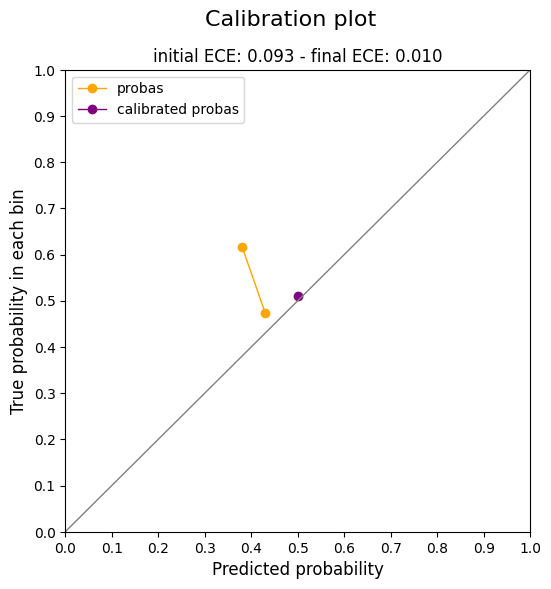

In [ ]:
learn.calibrate_model()
calibrated_model = learn.calibrated_model

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/021_calibration.ipynb saved at 2025-03-01 15:30:57
Correct notebook to script conversion! 😃
Saturday 01/03/25 15:31:00 CET
